# Ray et al 2013 Exploratory Data Analysis
**Authorship:**
Adam Klie (last updated: *06/09/2023*)
***
**Description:**
Notebook to perform a brief exploratory data analysis (EDA) on the Ray et al (2013) dataset.
***

In [8]:
# General imports
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# EUGENe imports
import eugene as eu
from eugene import plot as pl
from eugene import settings
settings.dataset_dir = "/cellar/users/aklie/data/eugene/revision/"

# EUGENe packages
import seqdatasets
import seqdata as sd
import seqpro as sp

# Print versions
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Xarray version: {xr.__version__}")
print(f"Eugene version: {eu.__version__}")
print(f"SeqDatasets version: {seqdatasets.__version__}")
print(f"SeqData version: {sd.__version__}")
print(f"SeqPro version: {sp.__version__}")

Python version: 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
NumPy version: 1.23.5
Pandas version: 1.5.2
Xarray version: 2023.4.0
Eugene version: 0.0.8
SeqDatasets version: 0.0.1
SeqData version: 0.0.1
SeqPro version: 0.0.1


# Download and load in the dataset to a raw `SeqData` object

In [2]:
# Load in the downloaded dataset from the RNAcomplete supplementary website and double check that the index and names loaded in correctly
sdata = seqdatasets.ray13(batch_size=10000)

Dataset ray13 norm_data.txt.gz has already been downloaded.


241357it [03:07, 1285.21it/s]


In [4]:
# Pull out the columns from seqs_annot to be used as targets (based on motif ID)
column_keys = pd.Index(sdata.data_vars.keys())
target_mask = column_keys.str.contains("RNCMPT")
target_cols = column_keys[target_mask]
len(target_cols)

244

# Sequence information

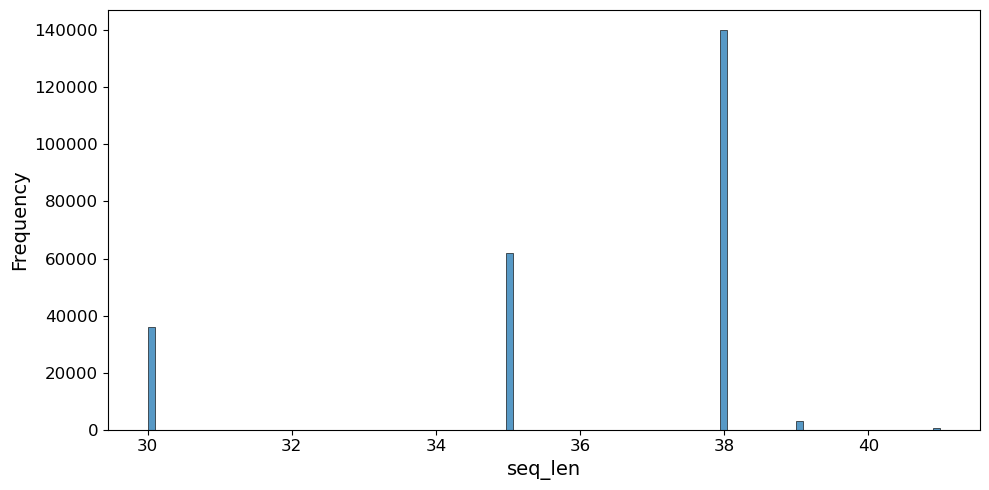

In [11]:
# Grab sequence lengths and plot distribution
sdata["seq_len"] = xr.DataArray(sp.length(sdata["seq"].values), dims="_sequence")
pl.histplot(
    sdata, 
    keys="seq_len", 
    orient="h"
)
plt.show()

# Target information

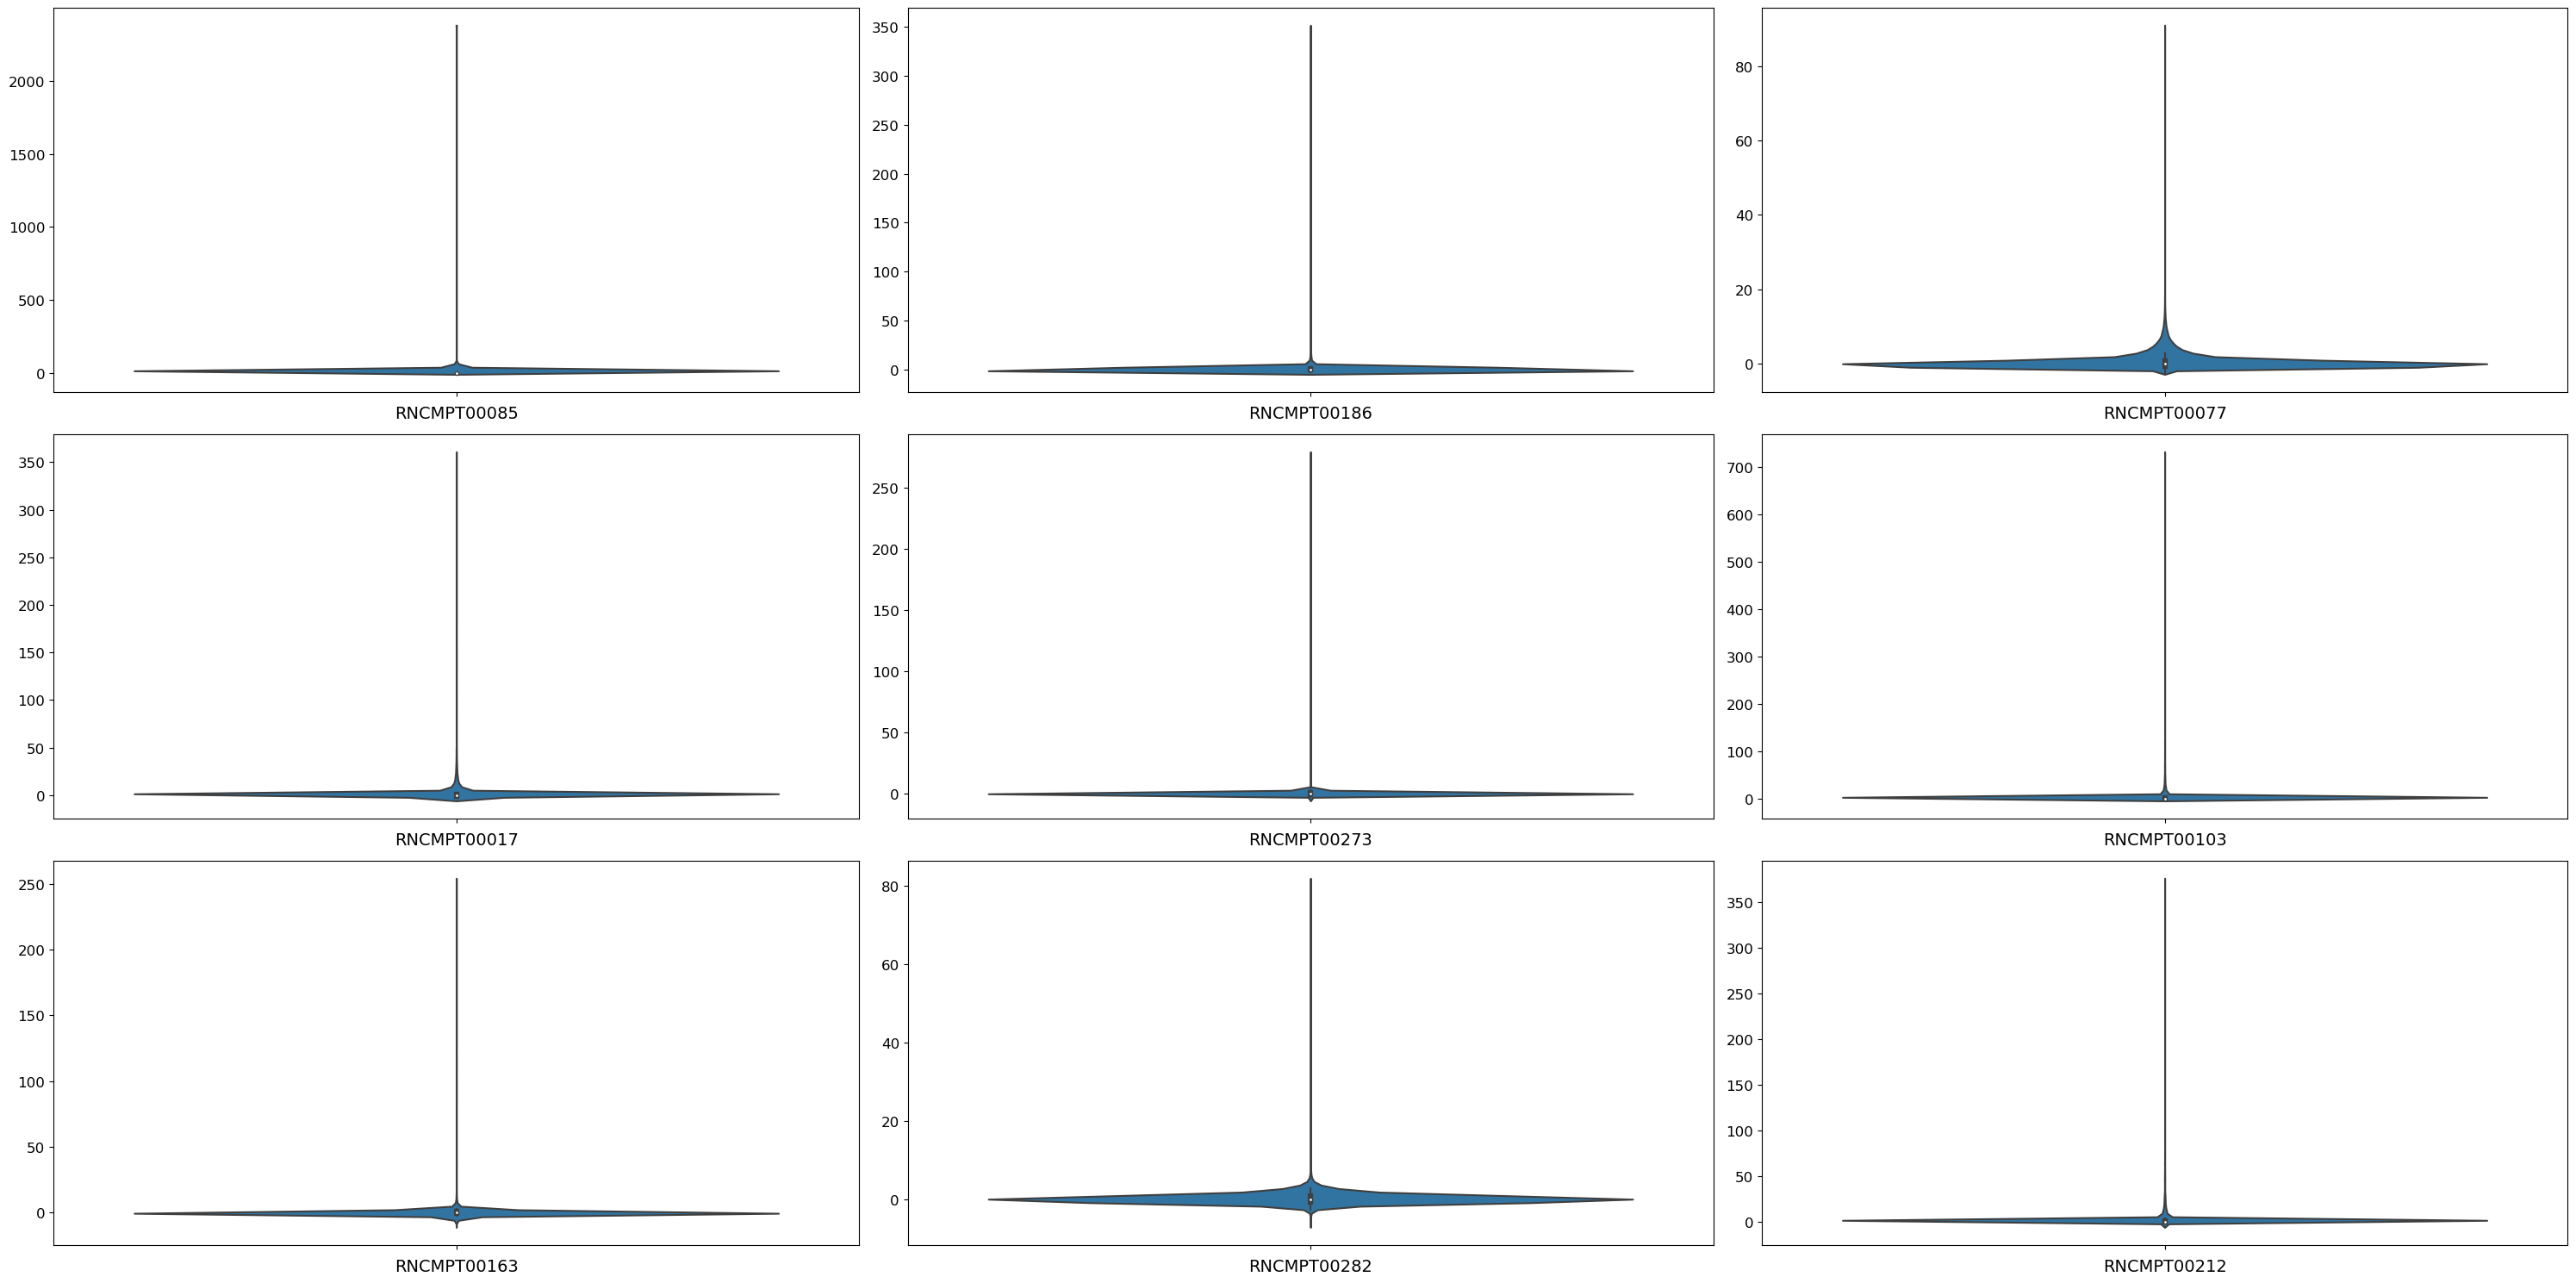

In [12]:
# Lets take a look at the distributions of a few randomly selected RBPs across all probes
pl.violinplot(
    sdata, 
    keys=list(np.random.choice(target_cols, 9))
)
plt.show()

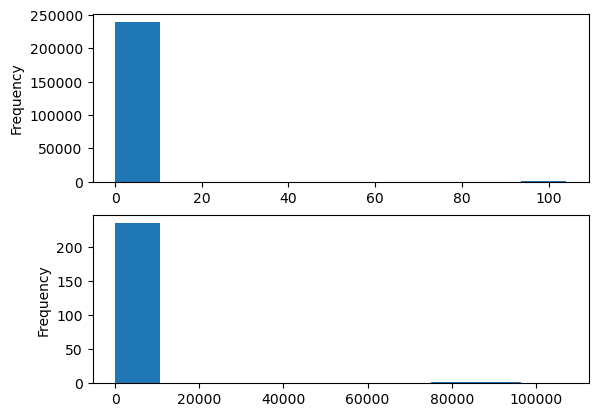

In [13]:
# Plot the number NaN values across target columns and across sequences
fig, ax = plt.subplots(nrows=2, ncols=1)
sdata[target_cols].to_dataframe().isna().sum(axis=1).plot(kind="hist", ax=ax[0])
sdata[target_cols].to_dataframe().isna().sum(axis=0).plot(kind="hist", ax=ax[1])
plt.show()

In [14]:
# Determine the number of targets that would be included in the dataset if we dropped those with > 1% NaN values
nan_percents = sdata[target_cols].to_dataframe().isna().sum(axis=0).sort_values(ascending=False)/sdata.dims["_sequence"]
cleaned_annot = sdata[target_cols].to_dataframe().drop(nan_percents[nan_percents > 0.01].index, axis=1)
cleaned_cols = target_cols.drop(nan_percents[nan_percents > 0.01].index)
cleaned_annot.head()

,RNCMPT00001,RNCMPT00002,RNCMPT00003,RNCMPT00004,RNCMPT00005,RNCMPT00006,RNCMPT00007,RNCMPT00010,RNCMPT00011,RNCMPT00012,...,RNCMPT00280,RNCMPT00281,RNCMPT00282,RNCMPT00283,RNCMPT00284,RNCMPT00285,RNCMPT00287,RNCMPT00288,RNCMPT00289,RNCMPT00291
_sequence,,,,,,,,,,,,,,,,,,,,,
0,-0.975763,-0.938189,-0.280471,-1.636150,-0.770653,217.358810,-0.735885,-0.500278,-0.965131,0.528585,...,0.213115,0.790010,1.387710,-0.884262,-0.523365,-1.020551,0.570525,2.041375,0.632329,-0.791802
1,-0.766150,-0.795771,0.657805,12.993121,2.012044,-0.952446,-0.665872,0.691741,0.777428,-0.767174,...,-0.386272,0.697056,-0.522816,7.300319,3.616368,5.934357,0.000000,-0.074133,0.446094,0.080122
2,2.291724,-0.210733,-0.951479,-1.400383,-0.993670,-0.328512,-0.224442,1.430164,0.607956,0.713995,...,0.799317,-0.923445,0.149444,-0.816875,0.836061,-0.241066,0.170298,-0.281612,-1.480840,0.998573
3,-0.490199,2.757162,0.797645,-0.360296,-1.109724,19.567248,3.318379,-2.483271,-0.869645,-0.373984,...,-0.303540,-0.690010,0.215857,-0.578328,1.285077,0.122848,0.748029,-0.130427,3.541057,-0.450953
4,0.203296,-0.433546,10.692211,2.893106,0.433878,-0.249422,-2.417125,-0.015830,-0.487119,-1.077079,...,-0.547772,0.000000,-0.637925,2.119010,2.046517,1.582206,0.112905,-0.390394,-0.365524,-0.388589


In [15]:
# Determine how many sequences would be included in the dataset if we dropped those with any NaN values
len(np.where(cleaned_annot[cleaned_cols].isna().sum(axis=1) == 0)[0])

221796

# DONE!

---

# Scratch

In [16]:
sdata = sd.open_zarr(os.path.join(settings.dataset_dir, "ray13", "ray13_norm.zarr"))

In [17]:
sdata

<xarray.Dataset>
Dimensions:      (_sequence: 241357)
Dimensions without coordinates: _sequence
Data variables: (12/247)
    Probe_ID     (_sequence) object dask.array<chunksize=(10000,), meta=np.ndarray>
    Probe_Set    (_sequence) object dask.array<chunksize=(10000,), meta=np.ndarray>
    RNCMPT00001  (_sequence) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    RNCMPT00002  (_sequence) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    RNCMPT00003  (_sequence) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    RNCMPT00004  (_sequence) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    ...           ...
    RNCMPT00285  (_sequence) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    RNCMPT00287  (_sequence) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    RNCMPT00288  (_sequence) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    RNCMPT00289  (_sequence) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    RNCMPT00291  (_sequence) float64 dask.array<chunksize=(10000,), meta=np.ndarray>
    seq          (_sequence) object dask.array<chunksize=(10000,), meta=np.ndarray>